<a href="https://colab.research.google.com/github/yoheikikuta/DeepGamblers-tensorflow/blob/master/colab/Deepgamblers_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Gamblers

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

TensorFlow 2.x selected.


In [2]:
tf.__version__

'2.0.0'

In [0]:
from tensorflow.keras import layers
import numpy as np

## MNIST data

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

In [146]:
train_images.shape

(60000, 28, 28, 1)

In [147]:
tf.one_hot(train_labels, depth=10)[0:3]

<tf.Tensor: id=182824, shape=(3, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

In [0]:
TRAIN_BUF = 60000
TEST_BUF = 10000
BATCH_SIZE = 100

In [0]:
train_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(train_images),
    tf.data.Dataset.from_tensor_slices(tf.one_hot(train_labels, depth=10))
))

test_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(test_images),
    tf.data.Dataset.from_tensor_slices(tf.one_hot(test_labels, depth=10))
))

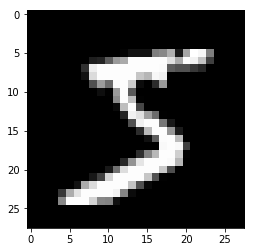

In [150]:
import matplotlib.pyplot as plt

plt.imshow(train_images[0].reshape((28, 28)), cmap="gray")

In [0]:
it = iter(train_dataset)

In [0]:
img, label = next(it)

In [153]:
label

<tf.Tensor: id=182849, shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)>

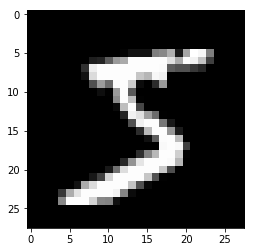

In [155]:
plt.imshow(img.numpy().reshape((28, 28)), cmap="gray")

## Model

In [0]:
class fourLayerCNN(tf.keras.Model):
    """Simple 4-layer CNN"""

    def __init__(self, o=6.0, output_dim=11, name='cnn', **kwargs) -> None:
        super(fourLayerCNN, self).__init__(name=name, **kwargs)
        self.o = o
        self.output_dim = output_dim
        self.input_layer = layers.InputLayer(input_shape=(28, 28, 1))
        self.conv2d_1 = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation='relu')
        self.conv2d_2 = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation='relu')
        self.conv2d_3 = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation='relu')
        self.conv2d_4 = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation='relu')
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(self.output_dim)
        self.prob = layers.Softmax()

    def call(self, inputs):
        x = self.input_layer(inputs)
        x = self.conv2d_1(x)
        x = self.conv2d_2(x)
        x = self.conv2d_3(x)
        x = self.conv2d_4(x)
        x = self.flatten(x)
        x = self.dense(x)
        prob = self.prob(x)
        return prob
    
    def weighted_prob(self, inputs):
        prob = self.call(inputs)
        class_pred, abstention = tf.split(prob, [self.output_dim - 1, 1], 1)
        abstention /= self.o
        return tf.concat([class_pred, abstention], 1)

In [0]:
def compute_loss(model, x, y):
    weighted_prob = model.weighted_prob(x)
    label_shape = y.shape
    extended_label = tf.concat([y, tf.constant(1.0, shape=[label_shape[0], 1])], 1)
    log_arg = tf.reduce_sum(extended_label * weighted_prob, 1)
    cross_ent = -tf.reduce_sum(tf.math.log(log_arg))
    return cross_ent

In [0]:
def train(model, optimizer, test_loss, train_dataset, test_dataset):
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, x_batch_train, y_batch_train)

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

    for (x_batch_test, y_batch_test) in test_dataset:
        test_loss(compute_loss(model, x_batch_test, y_batch_test))

## Training

In [0]:
import time

In [0]:
train_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(train_images),
    tf.data.Dataset.from_tensor_slices(tf.one_hot(train_labels, depth=10))
)).shuffle(TRAIN_BUF).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices(test_images),
    tf.data.Dataset.from_tensor_slices(tf.one_hot(test_labels, depth=10))
)).batch(BATCH_SIZE)

In [20]:
start = time.time()
cnn = fourLayerCNN(o=6.0, output_dim=11)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

for epoch in range(2):
    print(f"Start of epoch {epoch + 1}")
    test_loss = tf.keras.metrics.Mean()
    train(cnn, optimizer, test_loss, train_dataset, test_dataset)
    print(f"  test loss: {test_loss.result()}")

end = time.time()
print(f"TRAINING TIME: {end - start} [sec]")

Start of epoch 1
  test loss: 15.1285400390625
Start of epoch 2
  test loss: 7.25223445892334
TRAINING TIME: 563.1621036529541 [sec]


## Check the trained model

In [0]:
%%time

predictions = np.array([], dtype=np.float32).reshape(0, 11)

for (x_batch_test, y_batch_test) in test_dataset:
    pred = cnn(x_batch_test)
    predictions = np.vstack([predictions, pred])

In [52]:
predictions.shape

(10000, 11)

In [0]:
abstention_scores = []

for idx, elem in enumerate(predictions):
    abstention_scores.append((elem[-1], idx))

abstention_scores = sorted(abstention_scores, reverse=True)

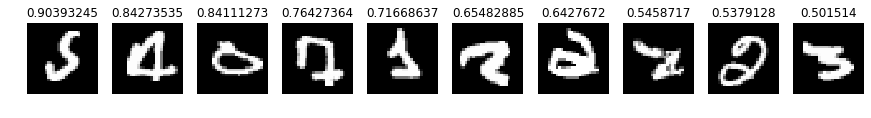

In [140]:
def draw_digit(data, title, row, col, n):
    plt.subplot(row, col, n)
    plt.imshow(data)
    plt.gray()
    plt.title(title)
    plt.axis("off")

show_size = 10

plt.figure(figsize=(15,20))
total = 0
for i, (score, idx) in enumerate(abstention_scores[:10]):
    draw_digit(test_images[idx].reshape(28, 28), str(score), 1, show_size, total+1)
    total += 1
plt.show()

In [0]:
def acc_with_thld(thld):
    result = []
    for pred, ans in zip(predictions, test_labels):
        if pred[-1] > thld:
            continue
        pred_label = np.argmax(pred)
        result.append(pred_label == ans)
    coverage = len(result) / len(test_labels)
    acc = sum(result) / len(result)
    return coverage, acc

In [132]:
for thld in np.arange(1.0, 0.0, -0.1):
    coverage, acc = acc_with_thld(thld)
    print(f"Threshold: {thld:.1f}, Coverage : {coverage:.4f}, Accuracy : {acc:.4f}")

Threshold: 1.0, Coverage : 1.0000, Accuracy : 0.9769
Threshold: 0.9, Coverage : 0.9999, Accuracy : 0.9770
Threshold: 0.8, Coverage : 0.9997, Accuracy : 0.9772
Threshold: 0.7, Coverage : 0.9995, Accuracy : 0.9774
Threshold: 0.6, Coverage : 0.9993, Accuracy : 0.9776
Threshold: 0.5, Coverage : 0.9990, Accuracy : 0.9779
Threshold: 0.4, Coverage : 0.9987, Accuracy : 0.9781
Threshold: 0.3, Coverage : 0.9980, Accuracy : 0.9783
Threshold: 0.2, Coverage : 0.9966, Accuracy : 0.9788
Threshold: 0.1, Coverage : 0.9935, Accuracy : 0.9797


## Trial and Errors

In [0]:
a = [1, 2, 3, 4, 5]

In [0]:
a[:-1]

[1, 2, 3, 4]

In [0]:
a[-1]

5

In [0]:
test_model = fourLayerCNN(1.2)

In [0]:
check_data = tf.constant(train_images[0])

In [0]:
check_data.shape

TensorShape([28, 28, 1])

In [0]:
tf.shape(tf.expand_dims(check_data, 0))  # Add batch dim.

<tf.Tensor: id=1601, shape=(4,), dtype=int32, numpy=array([ 1, 28, 28,  1], dtype=int32)>

In [0]:
prob = test_model(tf.expand_dims(check_data, 0))

In [0]:
prob.shape

TensorShape([1, 11])

In [0]:
abstention = test_model.weighted_prob(tf.expand_dims(check_data, 0))

InvalidArgumentError: ignored

In [0]:
a = tf.constant([[0,1,2,3,4,5,6,7,8,9,10]], dtype=tf.float32)

In [0]:
a.shape

TensorShape([1, 11])

In [0]:
tf.slice(a, [:, 0], [:, 3])

SyntaxError: ignored

In [0]:
b, c = tf.split(a, [10, 1], 1)

In [0]:
b, c

(<tf.Tensor: id=1264, shape=(1, 10), dtype=float32, numpy=array([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]], dtype=float32)>,
 <tf.Tensor: id=1265, shape=(1, 1), dtype=float32, numpy=array([[10.]], dtype=float32)>)

In [0]:
c / 2.0

<tf.Tensor: id=1267, shape=(1, 1), dtype=float32, numpy=array([[5.]], dtype=float32)>

In [0]:
tf.concat([b, c], 1)

<tf.Tensor: id=1270, shape=(1, 11), dtype=float32, numpy=
array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]],
      dtype=float32)>

In [0]:
test_model.weighted_prob(tf.expand_dims(check_data, 0))

<tf.Tensor: id=1781, shape=(1, 11), dtype=float32, numpy=
array([[ 0.       ,  0.8333333,  1.6666666,  2.5      ,  3.3333333,
         4.1666665,  5.       ,  5.833333 ,  6.6666665,  7.4999995,
        10.       ]], dtype=float32)>

In [0]:
tf.one_hot(train_labels, depth=10)[0:3]

<tf.Tensor: id=1813, shape=(3, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

In [0]:
tf.data.Dataset.from_tensors(tf.one_hot(train_labels, depth=10))

<TensorDataset shapes: (60000, 10), types: tf.float32>

In [0]:
train_dataset

<ZipDataset shapes: ((28, 28, 1), (10,)), types: (tf.float32, tf.float32)>

In [0]:
shape = label.shape

In [0]:
shape[0]

NameError: ignored

In [0]:
class fourLayerCNN(tf.keras.Model):
    """Simple 4-layer CNN"""

    def __init__(self, o=4.4, output_dim=11, name='cnn', **kwargs) -> None:
        super(fourLayerCNN, self).__init__(name=name, **kwargs)
        self.o = o
        self.output_dim = output_dim
        self.input_layer = layers.InputLayer(input_shape=(28, 28, 1))
        self.conv2d_1 = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation='relu')
        self.conv2d_2 = layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation='relu')
        self.dropout = layers.Dropout(rate=0.2)
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(self.output_dim)
        self.prob = layers.Softmax()

    def call(self, inputs):
        x = self.input_layer(inputs)
        x = self.conv2d_1(x)
        x = self.conv2d_2(x)
        x = self.conv2d_3(x)
        x = self.conv2d_4(x)
        x = self.flatten(x)
        x = self.dense(x)
        prob = self.prob(x)
        return prob

In [0]:
def compute_loss(model, x, y):
    weighted_prob = model(x)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=weighted_prob, labels=y)
    return cross_ent

In [133]:
abstention_scores[:3]

[(0.90393245, 9982), (0.84273535, 5888), (0.84111273, 717)]

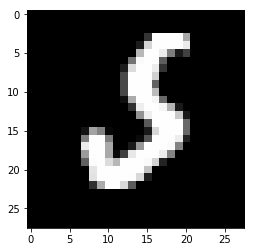

In [136]:
plt.imshow(test_images[9982].reshape(28, 28), cmap="gray")